shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
(1024, 1024)


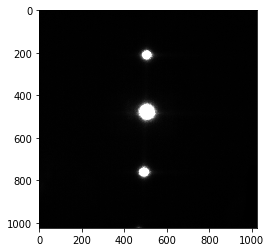

(1080, 1920)
TIME:  0.42433595657348633


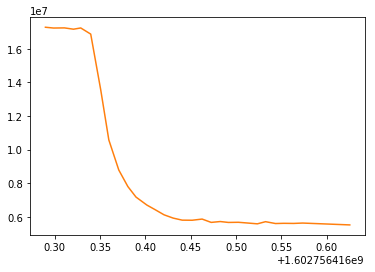

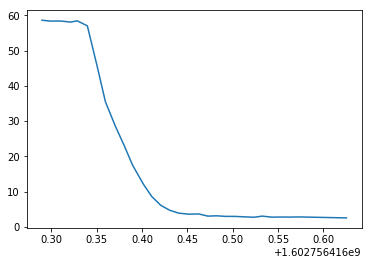

In [70]:
# IMPORTING PACKAGES REQUIRED TO RUN THE EXPERIMENT

import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2
import copy
import os
from os.path import isfile, join
import sys
import argparse

# TAKING COMMAND LINE ARGUMENTS

# total arguments 
n = len(sys.argv) 
print("Total arguments passed:", n) 
  
# Arguments passed 
print("\nName of Python script:", sys.argv[0]) 
  
print("\nArguments passed:", end = " ")
for i in sys.argv:
    print(i, end = " ")

date = str(sys.argv[1])
month = str(sys.argv[2])
sidelength = int(sys.argv[3])
datemonth = date + '_' + month

# CREATING OUTPUT FOLDER TO STORE DATA

main_dir = "slm_response_" + datemonth
os.mkdir(main_dir)

# DEFINING HORIZONTAL BINARY GRATING FUNCTION
def grating(shape):
    mask = np.zeros(shape)
    
    idx = [2*i for i in range(shape[0]//2)]
    mask[idx,:]=128
    
    return mask
###############################################


# EXPERIMENT TO CAPTURE TARGET IMAGE

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px

size = [sidelength, sidelength]

data_init = slmdisplaysdk.createFieldUChar(size[1],size[0])
#data = slmdisplaysdk.createFieldUChar(512,512)
size = data_init.shape
print("shape is: ", data_init.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data_init = 2*np.pi*grating(data_init.shape)/256
print(data_init)
error = slm.showPhasevalues(data_init)

camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

#camera.OffsetX.SetValue(600)
#camera.OffsetY.SetValue(0)
#camera.Width.SetValue(2048-600)
#camera.Height.SetValue(1088-88)
numberOfImagesToGrab = 1
camera.StartGrabbingMax(numberOfImagesToGrab)

while camera.IsGrabbing():
   
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

    if grabResult.GrabSucceeded():
        # Access the image data.
        img = np.asarray(grabResult.Array) #.reshape((grabResult.Height, grabResult.Width))
        
        print(img.shape)

        

    grabResult.Release()
    
print(img.shape)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
#plt.show()    
camera.Close()


np.save(main_dir + "/target"+ str(size[0]) + '_' + datemonth, img)
img = np.load(main_dir + "/target"+ str(size[0]) + '_' + datemonth + '.npy')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
print(img.shape)
#plt.show()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
#slm.close()
# Wait until the SLM process is closed:
#error = slm.utilsWaitUntilClosed()
#assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
#slm = None


# EXPERIMENT TO MEASURE RESPONSE TIME OF THE SLM W.R.T THE CAPTURED IMAGE AND BROADCASTED GRATING ABOVE

# INITIALIZING INSTRUMENTS (CAMERA AND SLM)
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Make some enumerations available locally to avoid too much code:
#ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
#ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
#slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
#if not slm.requiresVersion(2):
#    exit(1)

# Detect SLMs and open a window on the selected SLM
#error = slm.open()
#assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
#from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

sizerand = (dataHeight,dataWidth)

# Initialize random binary bitmap, and show it on the SLM:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = np.pi*(np.sign(np.random.normal(0,1,sizerand)+1e-7) + 1)/2
#print(data)
error = slm.showPhasevalues(data)

# DEFINING COST FUNCTION
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this
TargetIntensity = np.load(main_dir + '/target' + str(size[0]) + '_' + datemonth + '.npy')
print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.title("Target Image captured by camera")
plt.savefig(main_dir + "/target" + str(size[0]) + '_' + datemonth + ".png")
#plt.show()

numberOfImagesToGrab = 30

count = 0
COST = []
img = []
TIME = []
E = []
time_start = time.time()

# Reserve memory for grating to be shown, then show grating
data2 = slmdisplaysdk.createFieldUChar(size[0],size[1])
data2 = np.pi*grating(size)/128
time_start = time.time()

error = slm.showPhasevalues(data2) # SHOW GRATING 
camera.StartGrabbingMax(numberOfImagesToGrab)
while camera.IsGrabbing():
    grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
    if grabResult.GrabSucceeded():
        # Access the image data.
        img.append(grabResult.Array)
        TIME.append(time.time())
    else:
        print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
    count += 1
    #cv2.imwrite('with_phase_06_10/with_phase'+ str(iter) + '.png', img[-1])
    
    
time_end = time.time()
print(data2.shape)
print("TIME: ", time_end-time_start)

# WRITING FRAMES CAPTURED BY CAMERA INTO A VIDEO
fps = 1
sizevid = (img[1]).shape
pathOut = main_dir + '/response' + str(size[0]) + datemonth + '.avi'
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, sizevid)

for i in range(30):
   COST.append(cost(TargetIntensity, img[i]))
   E.append(np.sum(img[i]))
   gray = cv2.normalize(img[i], None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
   gray_3c = cv2.merge([gray, gray, gray])
   out.write(gray_3c)
   
out.release()
#plt.plot(TIME, E)
#plt.show()
#plt.plot(TIME, COST)
#plt.show()

print("COST = ", COST)
print("Energy = ", E)
print("TIME = ", TIME)
time2 = []
for i in TIME:
    current_milli_time = lambda: int(round((i - TIME[0])*1000))
    time2.append(current_milli_time())
    
print("Time in milliseconds = ", time2)

# CREATING AND SAVING PLOTS OF THE RESPONSE

fig, ax = plt.subplots(2,1)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.tight_layout(pad=4)
fig.suptitle("Response time of SLM when a binary horizontal grating of " + str(size[0]) + "x" + str(size[1]) + "pixels is uploaded", fontsize=20)
ax[0].plot(time2, COST)
ax[0].set_xlabel("Time in milliseconds", fontsize=15)
ax[0].set_ylabel("Cost function", fontsize=15)
ax[1].plot(time2, E)
ax[1].set_xlabel("Time in milliseconds", fontsize=15)
ax[1].set_ylabel("Energy", fontsize=15)

plt.savefig(main_dir + "/response" + str(size[0]) + "_" + datemonth + ".png")
#plt.show()

plt.imshow(data2, cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("Grating shown on SLM")
plt.colorbar()
plt.savefig(main_dir + "/grating" + str(size[0]) + "_" + datemonth + ".png")


# CLOSING DOWN THE INSTRUMENTS

camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None